In [27]:
import pandas as pd
import numpy as np
np.random.seed(1907)

#For classification
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#For visualisation
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns


#To remove stopwords
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
#Remove stopwords for easier parsing afterwards
stop_words = list(stopwords.words("english"))

df = pd.read_csv("../../data/abstract_dataset.csv",header=None)
df.columns = ["title","DOI","Abstract","Task"]
df.head(5)

[nltk_data] Downloading package stopwords to /home/theo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,title,DOI,Abstract,Task
0,nnU-Net: a self-configuring method for deep le...,10.1038/s41592-020-01008-z,biomedical imaging is a driver of scientific d...,Cardiac
1,Automated cardiovascular magnetic resonance im...,10.1186/s12968-018-0471-x,cardiovascular resonance cmr imaging is a stan...,Cardiac
2,Deep Learning for Cardiac Image Segmentation: ...,10.3389/fcvm.2020.00025,deep learning has become the most widely used ...,Cardiac
3,Deep Learning for Segmentation Using an Open L...,10.1109/tmi.2019.2900516,delineation of the cardiac structures from 2d ...,Cardiac
4,Multi-Scale Self-Guided Attention for Medical ...,10.1109/jbhi.2020.2986926,even though convolutional neural networks cnns...,Cardiac


## Data Analysis

### Task representation

<AxesSubplot: xlabel='count', ylabel='Task'>

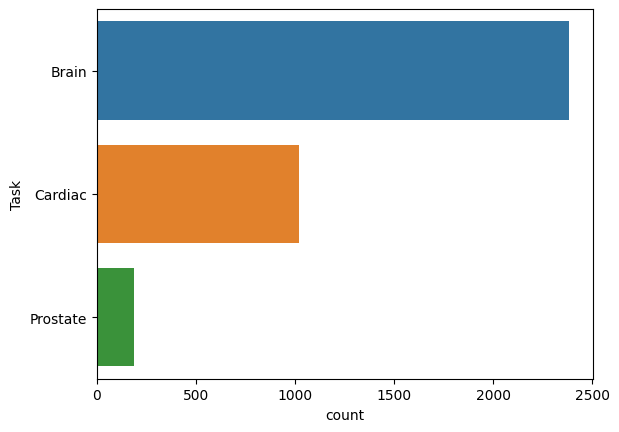

In [2]:
sns.countplot(data=df,y='Task',order=df["Task"].value_counts().index)

Note: imbalanced class distribution , not a lot of exemples for Prostate class

### Wordcloud per task without tf-idf

Plot of most frequent word in paper abstracts for each task

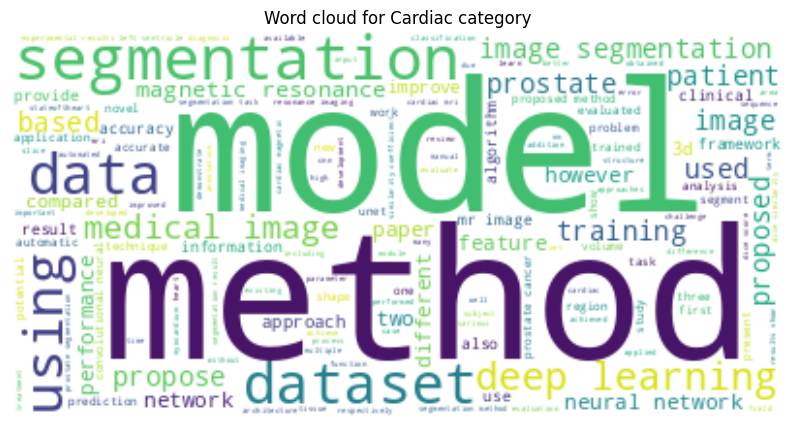

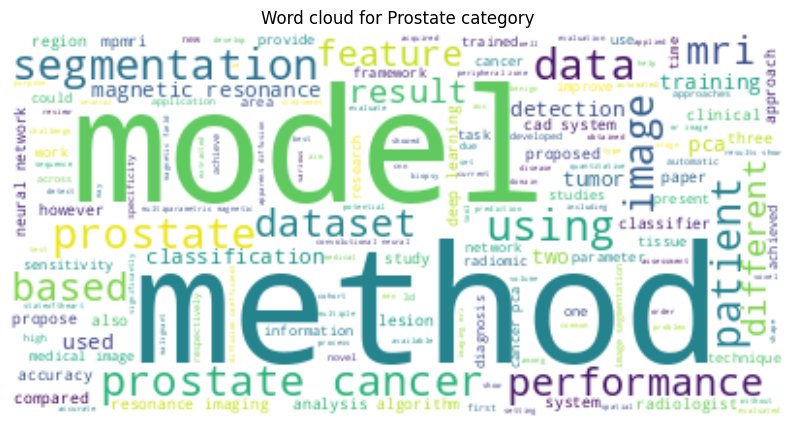

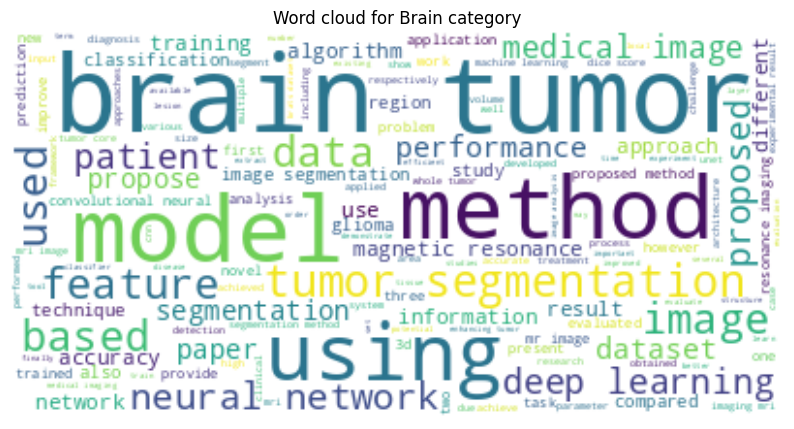

In [3]:
for task in df["Task"].unique():
    #Get text of the category
    task_df = df[df["Task"]==task]
    text = ' '.join(task_df["Abstract"])

    #Plot
    wordcloud = WordCloud(stopwords=stop_words,background_color="white").generate(text)
    
    plt.figure(figsize=(10,10))
    plt.title(f"Word cloud for {task} category")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

### Wordcloud per task with tf-idf

Plot of most frequent word in paper abstracts for each task using tf-idf over the whole dataset (not 1 tf-idf per task)

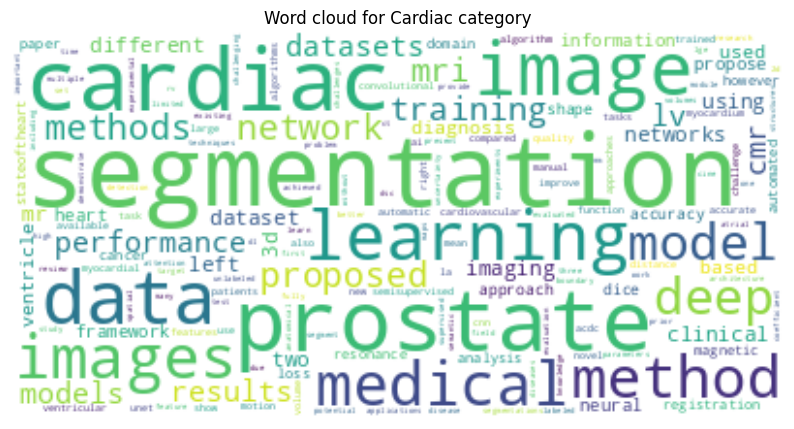

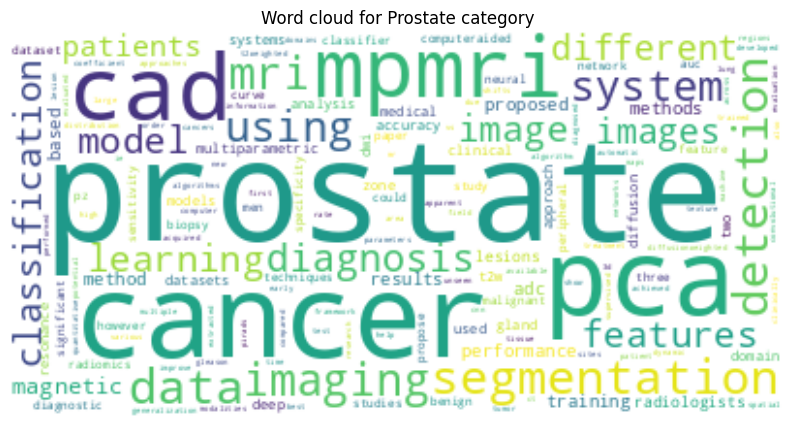

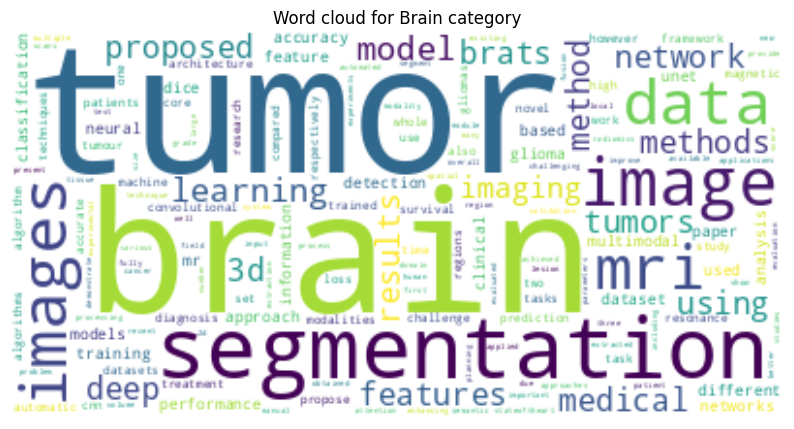

In [4]:
corpus = df["Abstract"].to_list()
vectorizer = TfidfVectorizer(stop_words=stop_words)
vecs = vectorizer.fit(corpus)
feature_names = vectorizer.get_feature_names_out()

for task in df["Task"].unique():
    #Get text of the category
    task_df = df[df["Task"]==task]
    corpus = task_df["Abstract"].to_list()
    vecs = vectorizer.transform(corpus)
    dense = vecs.todense()
    lst1 = dense.tolist()
    df_tf_idf = pd.DataFrame(lst1, columns=feature_names)

    x = df_tf_idf.T.sum(axis=1)
    #Plot
    wordcloud = WordCloud(stopwords=stop_words,background_color="white").generate_from_frequencies(x)
    
    plt.figure(figsize=(10,10))
    plt.title(f"Word cloud for {task} category")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

Notes: presence of word "prostate" when using tf-idf with cardiac task papers may lead to problem

## Classification

In [33]:
np.random.seed(1907)

train,test = train_test_split(df,test_size=0.2)
test,dev = train_test_split(test,test_size=0.5)

X_train = train["Abstract"].to_list()
X_dev = dev["Abstract"].to_list()
X_test = test["Abstract"].to_list()

y_train = train["Task"].to_list()
y_dev = dev["Task"].to_list()
y_test = test["Task"].to_list()

vectorizer = TfidfVectorizer(max_features=100,stop_words=stop_words)
vectorizer.fit(X_train)
X_train_tf = vectorizer.transform(X_train)
X_dev_tf = vectorizer.transform(X_dev)
X_test_tf = vectorizer.transform(X_test)


rf_classifier = RandomForestClassifier(n_estimators=200)
rf_classifier.fit(X_train_tf,y_train)

Train accuracy: 0.8857938718662952


## Error Analysis

Train accuracy: 0.8857938718662952


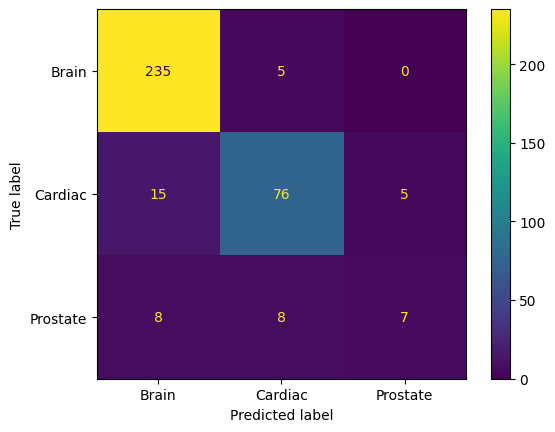

In [34]:
print(f"Train accuracy: {rf_classifier.score(X_dev_tf,y_dev)}")
y_pred = rf_classifier.predict(X_dev_tf)

cm = confusion_matrix(y_dev,y_pred)
disp = ConfusionMatrixDisplay(cm,display_labels=rf_classifier.classes_)
disp.plot()

Note: Poor results on Prostate class but good ones on Brain and Cardiac. Multiple possible reasons for the prostate class results, not enough exemples for Prostate class or maybe papers that reference Prostate dataset often reference other task dataset.